This is the opposite of the previous notebook, but the idea is still the same.

In [2]:
import pandas as pd
import numpy as np
from pycaret.regression import setup, compare_models, predict_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error


In [3]:
google_data = pd.read_csv("../GOOGL_stock_data.csv", parse_dates=["Date"])
meta_data = pd.read_csv("../META_stock_data.csv", parse_dates=["Date"])


In [4]:
# Create lag features and moving averages for Meta
meta_data["Lag_1_meta"] = meta_data["Close"].shift(1)
meta_data["Lag_2_meta"] = meta_data["Close"].shift(2)
meta_data["50_MA_meta"] = meta_data["Close"].rolling(window=50).mean()
meta_data["200_MA_meta"] = meta_data["Close"].rolling(window=200).mean()

# Drop rows with NaN values due to lagging and moving averages
meta_data.dropna(inplace=True)

In [5]:
# Merge Google and Meta datasets on Date
combined_data = pd.merge(google_data, meta_data, on="Date", suffixes=("_google", "_meta"))

# Define features (X) from Meta and target variable (y) as Google prices
X = combined_data[["Lag_1_meta", "Lag_2_meta", "50_MA_meta", "200_MA_meta"]]
y = combined_data["Close_google"]

# Split into training and testing sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [6]:
# Prepare training data for PyCaret setup
train_data = X_train.copy()
train_data["Close_google"] = y_train.values

# Initialize PyCaret for regression
pycaret_setup = setup(
    data=train_data,
    target="Close_google",
    numeric_features=["Lag_1_meta", "Lag_2_meta", "50_MA_meta", "200_MA_meta"],
    session_id=123,
    fold_strategy="timeseries",
    fold=5,
    data_split_shuffle=False
)


,Description,Value
0,Session id,123
1,Target,Close_google
2,Target type,Regression
3,Original data shape,"(2348, 5)"
4,Transformed data shape,"(2348, 5)"
5,Transformed train set shape,"(1643, 5)"
6,Transformed test set shape,"(705, 5)"
7,Numeric features,4
8,Preprocess,True
9,Imputation type,simple


In [8]:
# Compare models and choose the best one
final_model = compare_models()


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,4.3130,31.6782,5.1627,-1.4420,0.1231,0.0989,0.0360
ada,AdaBoost Regressor,4.4151,32.5370,5.2528,-1.5476,0.1257,0.1014,0.0180
rf,Random Forest Regressor,4.3780,31.7159,5.2680,-1.6152,0.1256,0.1007,0.0400
et,Extra Trees Regressor,4.4781,32.4509,5.3351,-1.6665,0.1271,0.1026,0.0320
dt,Decision Tree Regressor,4.5533,34.2236,5.4566,-1.7790,0.1268,0.1018,0.0060
knn,K Neighbors Regressor,4.6291,34.0848,5.5016,-1.9325,0.1323,0.1071,0.0140
omp,Orthogonal Matching Pursuit,3.7013,21.4443,4.2907,-1.9423,0.0987,0.0852,0.2060
lightgbm,Light Gradient Boosting Machine,4.9159,38.0080,5.8329,-2.3127,0.1403,0.1131,0.1740
lasso,Lasso Regression,4.2225,25.3709,4.8145,-4.7820,0.1148,0.1044,0.2300
llar,Lasso Least Angle Regression,4.2225,25.3662,4.8139,-4.7853,0.1148,0.1044,0.2380


And again, another example that suggest that Google's stock prices may have more predictive power for Meta's stock trends than the reverse. 

In [9]:
# Prepare test data for predictions
test_data = X_test.copy()
test_data["Close_google"] = y_test.values

# Predict using the trained model
predictions = predict_model(final_model, data=test_data)

# Add predictions to the test dataset for comparison
test_data["Predicted"] = predictions["prediction_label"]


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,70.4971,5536.9469,74.4107,-6.3784,0.7648,0.5265


In [10]:
# Calculate evaluation metrics
rmse = mean_squared_error(test_data["Close_google"], test_data["Predicted"], squared=False)
mape = mean_absolute_percentage_error(test_data["Close_google"], test_data["Predicted"])

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")


RMSE: 74.41066385866756
MAPE: 0.5264524737950369


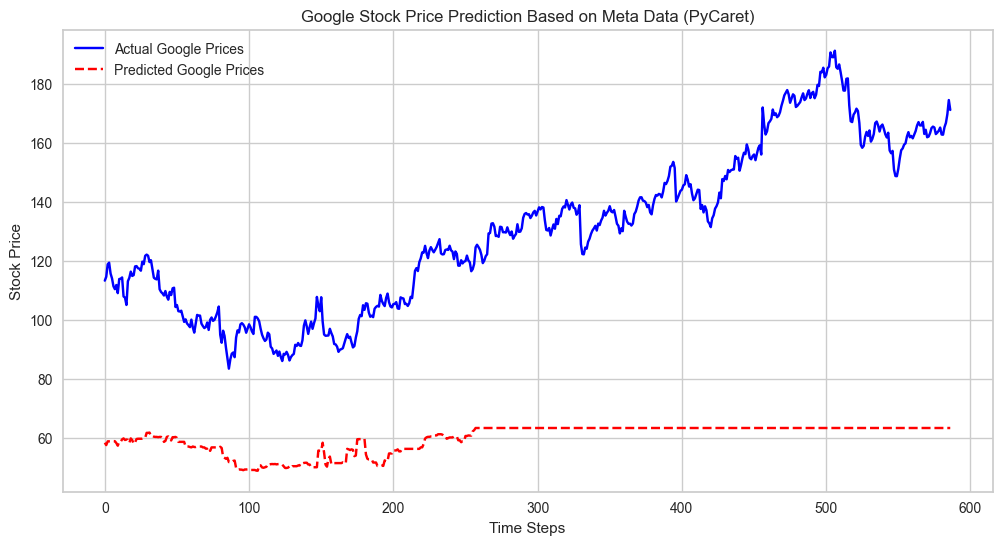

In [12]:
# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(test_data["Close_google"].values, label="Actual Google Prices", color="blue")
plt.plot(test_data["Predicted"].values, label="Predicted Google Prices", color="red", linestyle="--")
plt.title("Google Stock Price Prediction Based on Meta Data (PyCaret)")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.legend()
plt.show()
